In [1]:
# Speed and stress - Figure 11

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer
from matplotlib import cm
from datetime import datetime
from pyproj import Transformer
from scipy.ndimage import convolve

# right now, this loads the output into ds_CSYV
%run -i ncbx_funcs.py

Shape of xisl, yisl:  (1057, 1317) (1057, 1317)
Index of shoreline and y-location:
[168] [329.27781985]
Offshore model domain (dy_offshore):  [4453.85735021] , onshore (dy_onshore):  [5530.01136684]


In [2]:
eta_rho = ds_CSYV.sizes['eta_rho']
xi_rho = ds_CSYV.sizes['xi_rho']
s_rho = ds_CSYV.sizes['s_rho']
print(f"eta_rho = {eta_rho}, xi_rho = {xi_rho}")
print(f"s_rho = {s_rho}")
print(np.shape(xisl))

eta_rho = 1057, xi_rho = 1317
s_rho = 8
(1057, 1317)


In [3]:
# contour levels
levels = np.array( [-6, -4, -2, 0., 2.] ) # bathy
zlevels = np.arange(1, 2.75, .25) # water levels

# Smoothing kernal
ik = 15
k = np.ones((ik, ik)) / (ik*ik)

# pick a time index
# 0, 19, and 31
idx = 19
#for idx in np.arange(0, len(tstring), 2 ):

# Zoom in
xs = 950
xe = 1650
ys = -150
ye = 450

# load bathy and smooth for contouring
bath = np.squeeze( -ds_CSYV.bath[idx,:,:].load().values )
baths = convolve(bath,k,mode='nearest')

# load water elevation and mask dry regions
zeta = np.squeeze( ds_CSYV.zeta[idx,:,:].load().values )
wdm = np.squeeze( ds_CSYV.wetdry_mask_rho[idx,:,:].load().values )
zeta = despeckle( mask_array( zeta, wdm ) )

bustrc = np.squeeze( ds_CSYV.bustrc[idx,:,:].load().values )
bustrw = np.squeeze( ds_CSYV.bustrw[idx,:,:].load().values )
bvstrc = np.squeeze( ds_CSYV.bvstrc[idx,:,:].load().values )
bvstrw = np.squeeze( ds_CSYV.bvstrw[idx,:,:].load().values )
ustrc = np.sqrt(bustrc**2+bvstrc**2)
ustrw = np.sqrt(bustrw**2+bvstrw**2)
taucw = np.sqrt( ustrc**2 + ustrw**2)

ustrc = despeckle( mask_array( ustrc, wdm ) )
ustrw = despeckle( mask_array( ustrw, wdm ) )
taucw = despeckle( mask_array( taucw, wdm ) )
print('max ustrc:',np.nanmax(ustrc))
print('max ustrw:',np.nanmax(ustrw))
print('max taucw:',np.nanmax(taucw))

# load velocities
u = despeckle( mask_array( np.squeeze( ds_CSYV.ubar[idx,:,:].load().values),
                          np.squeeze( ds_CSYV.wetdry_mask_u[idx,:,:].load().values) ) )
v = despeckle( mask_array( np.squeeze( ds_CSYV.vbar[idx,:,:].load().values), 
                          np.squeeze( ds_CSYV.wetdry_mask_v[idx,:,:].load().values) ) )

uc = 0.5 * (u[0:-1,:]+u[1:,:])
vc = 0.5 * (v[:,0:-1]+v[:,1:])
# vc = np.pad(vc, ( (0,0), (1,1)), mode='edge')
# uc = np.pad(uc, ( (1,1), (0,0)), mode='edge')
print('uc:',np.shape(uc))
print('vc:',np.shape(vc))

max ustrc: 59.194168
max ustrw: 16.190924
max taucw: 59.194168
uc: (1056, 1316)
vc: (1056, 1316)


max spd: 5.411555
xd: (1057, 1317)
yd: (1057, 1317)
ud: (1056, 1316)
vd: (1056, 1316)


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_22372\1578896426.py:44: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m2 = ax2.pcolormesh(xisl, yisl, taucw, cmap='magma', vmin=0, vmax=60)
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_22372\1578896426.py:56: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m3 = ax3.pcolormesh(xd, yd, ustrc, cmap='magma',vmin=0, vmax=60, alpha = .9, zorder=0)
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_22372\1578896426.py:68: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasin

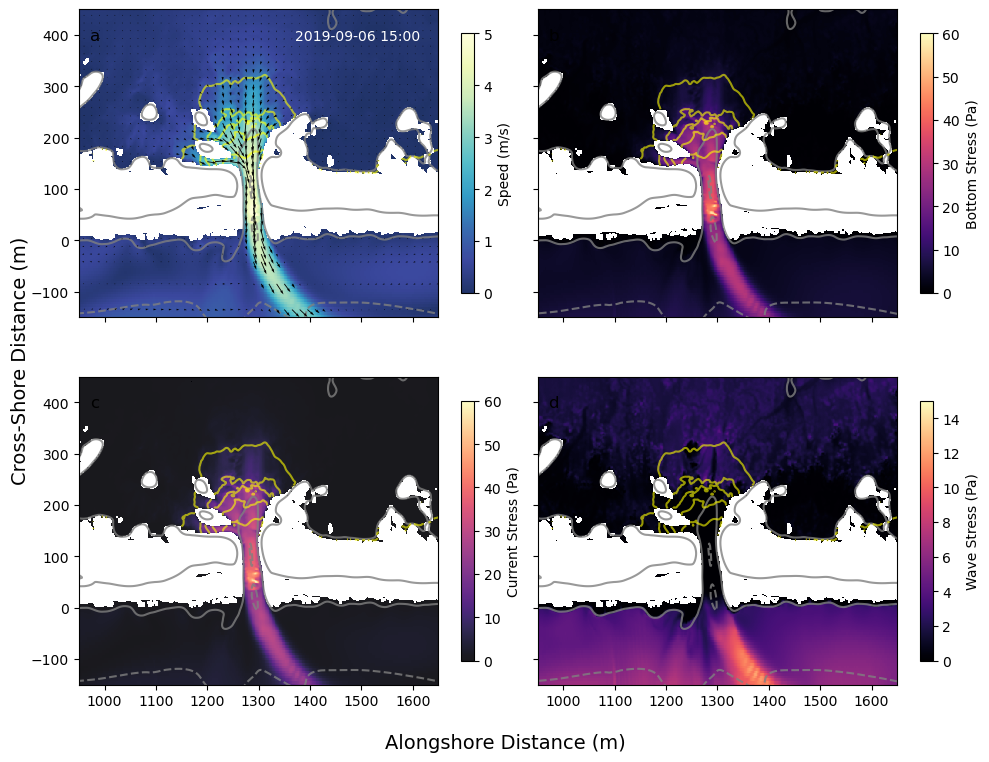

In [5]:
spd = np.sqrt( uc**2 + vc**2 )
print('max spd:',np.nanmax(spd))

# decimate velocities (for some reason, this makes u, v, and x, y the same shape
dfac = 1
xd = xisl[::dfac, ::dfac]
yd = yisl[::dfac, ::dfac]
ud = uc[::dfac, ::dfac]
vd = vc[::dfac, ::dfac]

ddfac = 10
udd = uc[::ddfac, ::ddfac]
vdd = vc[::ddfac, ::ddfac]
xdd = xisl[::ddfac, ::ddfac]
ydd = yisl[::ddfac, ::ddfac]
# scale vector near bottom left is 2 m/s
udd[2,5]=4.
vdd[2,5]=0.

print('xd:',np.shape(xd))
print('yd:',np.shape(yd))
print('ud:',np.shape(ud))
print('vd:',np.shape(vd))

abcde = ['a','b','c','d','e','f']

fig, axes  = plt.subplots(2, 2,figsize=(10,8),sharey=True, sharex=True)
ax1, ax2, ax3, ax4 = axes.ravel()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
m1 = ax1.pcolormesh(xd, yd, spd, cmap='YlGnBu_r',vmin=0, vmax=5, alpha = .9, zorder=0)
m1c = ax1.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
ax1.quiver(xdd, ydd, udd, vdd, color='black', alpha=1, zorder=2,scale=1./7., scale_units='xy', angles='xy')
m1s = ax1.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax1.text(.03, .9, abcde[0], fontsize=12, transform=ax1.transAxes )

cbar1 = plt.colorbar(m1, ax=ax1, shrink=.65)
cbar1.set_label(r'Speed (m/s)', rotation=90)

ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.set_aspect('equal')
ax1.text(0.95, 0.9, r'{}'.format(tstring[idx]), transform=ax1.transAxes, ha='right', c='white')

m2 = ax2.pcolormesh(xisl, yisl, taucw, cmap='magma', vmin=0, vmax=60)
m2c = ax2.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m2s = ax2.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)

ax2.set_xlim([xs, xe])
ax2.set_ylim([ys, ye])
ax2.set_aspect('equal')
cbar2 = plt.colorbar(m2, ax=ax2, shrink=.65)
cbar2.set_label(r'Bottom Stress (Pa)', rotation=90)
#ax2.text(0.95, 0.9, r'{}'.format(tstring[idx]), transform=ax2.transAxes, ha='right', c='white')
ax2.text(.03, .9, abcde[1], fontsize=12, transform=ax2.transAxes )

m3 = ax3.pcolormesh(xd, yd, ustrc, cmap='magma',vmin=0, vmax=60, alpha = .9, zorder=0)
m3c = ax3.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m3s = ax3.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax3.text(.03, .9, abcde[2], fontsize=12, transform=ax3.transAxes )

cbar3 = plt.colorbar(m3, ax=ax3, shrink=.65)
cbar3.set_label(r'Current Stress (Pa)', rotation=90)

ax3.set_xlim([xs, xe])
ax3.set_ylim([ys, ye])
ax3.set_aspect('equal')

m4 = ax4.pcolormesh(xisl, yisl, ustrw, cmap='magma', vmin=0, vmax=15)
m4c = ax4.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m4s = ax4.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax4.text(.03, .9, abcde[3], fontsize=12, transform=ax4.transAxes )

ax4.set_xlim([xs, xe])
ax4.set_ylim([ys, ye])
ax4.set_aspect('equal')
cbar4 = plt.colorbar(m4, ax=ax4, shrink=.65)
cbar4.set_label(r'Wave Stress (Pa)', rotation=90)
#x4.set_xlabel('Alongshore Distance (m)')

# Add shared axis labels
fig.supylabel('Cross-Shore Distance (m)', fontsize=14, x=0.005)
fig.supxlabel('Alongshore Distance (m)', fontsize=14)

fig.tight_layout(pad = .25)
plt.show()
fig.savefig('CSYV_4stress.png'.format(idx), dpi=200, bbox_inches='tight')

### Extract z level info

In [6]:
# These next two routines are from ChatGPT....not totally sure they are trustworthy

def set_depth(h, zeta, hc, N, Vtransform, Vstretching, theta_s, theta_b, grid='rho'):
    """
    Calculates z_rho (center of depth layers, N=N)
    """
    # Prevent division by zero and handle theta_s = 0
    theta_s_safe = np.maximum(theta_s, 1e-10)  # Ensure theta_s is not zero
    sc = (np.arange(1, N + 1) - N - 0.5) / N if grid == 'rho' else np.arange(0, N + 1) / N - 1

    # Handle Cs calculation more carefully to avoid NaN/Inf issues
    Cs = (1 - theta_b) * np.sinh(theta_s_safe * sc) / np.sinh(theta_s_safe) + \
         theta_b * (np.tanh(theta_s_safe * (sc + 0.5)) - np.tanh(theta_s_safe / 2)) / (2 * np.tanh(theta_s_safe / 2))

    # Ensure no invalid values propagate
    if np.any(np.isnan(Cs)) or np.any(np.isinf(Cs)):
        print("Warning: NaN or Inf values in Cs. Adjusting.")
        Cs = np.nan_to_num(Cs, nan=0.0, posinf=0.0, neginf=0.0)

    if Vtransform == 1:
        z = sc[:, np.newaxis, np.newaxis] * hc + Cs[:, np.newaxis, np.newaxis] * h
        z = z + zeta[np.newaxis, :, :] * (1 + z / h)
    elif Vtransform == 2:
        z = (hc * sc[:, np.newaxis, np.newaxis] + Cs[:, np.newaxis, np.newaxis] * h) / \
            (hc + h)
        z = zeta[np.newaxis, :, :] + (zeta[np.newaxis, :, :] + h) * z
    else:
        raise ValueError("Unsupported Vtransform version")

    return z


def set_depth_w(h, zeta, hc, N, Vtransform, Vstretching, theta_s, theta_b):
    """
    Calculate depths at layer interfaces (w-points), size N+1.
    """
    sc = np.arange(0, N + 1) / N - 1  # w-levels from -1 to 0
    theta_s_safe = np.maximum(theta_s, 1e-10)

    Cs = (1 - theta_b) * np.sinh(theta_s_safe * sc) / np.sinh(theta_s_safe) + \
         theta_b * (np.tanh(theta_s_safe * (sc + 0.5)) - np.tanh(theta_s_safe / 2)) / \
         (2 * np.tanh(theta_s_safe / 2))

    if Vtransform == 1:
        z = sc[:, np.newaxis, np.newaxis] * hc + Cs[:, np.newaxis, np.newaxis] * h
        z = z + zeta[np.newaxis, :, :] * (1 + z / h)
    elif Vtransform == 2:
        z = (hc * sc[:, np.newaxis, np.newaxis] + Cs[:, np.newaxis, np.newaxis] * h) / (hc + h)
        z = zeta[np.newaxis, :, :] + (zeta[np.newaxis, :, :] + h) * z
    else:
        raise ValueError("Unsupported Vtransform version")

    return z  # shape: (N+1, eta, xi)
    
#Hz=set_depth(Vtransform, Vstretching, theta_s, theta_b, hc, N, igrid, h, zeta, report)
#Hz=set_depth(2, 4, 0, 0, 0, 8, 1, h, zeta, 1
theta_s = ds_CSYV['theta_s'].values.item()
theta_b = ds_CSYV['theta_b'].values.item()
hc = ds_CSYV['hc'].values.item()
Vtransform = ds_CSYV['Vtransform'].values.item()
Vstretching = ds_CSYV['Vstretching'].values.item()
#
zetai = np.squeeze( ds_CSYV.zeta[idx,:,:].load().values )
z_w = set_depth_w(-bath, zetai, hc=hc, N=8, Vtransform=Vtransform,
                   Vstretching=Vstretching, theta_s=theta_s, theta_b=theta_b)
z_rho = set_depth(-bath, zetai, hc=hc, N=8, Vtransform=Vtransform, Vstretching=Vstretching, theta_s=theta_s, theta_b=theta_b, grid='rho')
print(np.shape(z_w))

(9, 1057, 1317)


### Calculate ssc and ssc flux

In [7]:
# N = 8
N=s_rho
Hz = np.zeros( (N, eta_rho, xi_rho) )
sscu = np.zeros( (N, eta_rho, xi_rho) )
sscv = np.zeros( (N, eta_rho, xi_rho) )
sscc = np.zeros( (N, eta_rho, xi_rho) )

ssc = np.squeeze( ds_CSYV.sand_01[idx,:,:,:].load().values + \
        ds_CSYV.sand_02[idx,:,:,:].load().values + \
        ds_CSYV.sand_03[idx,:,:,:].load().values)
print('ssc:',np.shape(ssc))

u_rho = 0.5 * (ds_CSYV.u[idx, :, :, :-1] + ds_CSYV.u[idx, :, :, 1:])
v_rho = 0.5 * (ds_CSYV.v[idx, :, :-1, :] + ds_CSYV.v[idx, :, 1:, :])
u_rho = np.pad(u_rho, ( (0,0), (0,0), (1,1)), mode='edge')
v_rho = np.pad(v_rho, ( (0,0), (1,1), (0,0)), mode='edge')
print(np.shape(Hz))
print(np.shape(u_rho))
print(np.shape(v_rho))

for ilevel in range(N):
    Hz[ilevel,:,:] = (z_w[ilevel+1,:,:]-z_w[ilevel,:,:])
    sscc[ilevel,:,:] = ssc[ilevel,:,:] * Hz[ilevel,:,:] 
    sscu[ilevel,:,:] = ssc[ilevel,:,:] * u_rho[ilevel,:,:] * Hz[ilevel,:,:] 
    sscv[ilevel,:,:] = ssc[ilevel,:,:] * v_rho[ilevel,:,:] * Hz[ilevel,:,:] 

depth = np.sum( Hz, axis=0 )
ssc_avg = np.sum( sscc, axis=0)/depth
sscu_avg = np.sum( sscu, axis=0)/depth
sscv_avg = np.sum( sscv, axis=0)/depth
ssc_flux = np.sqrt( sscu_avg**2 + sscv_avg**2 )

print(np.shape(depth))
print(np.max(depth))
print(np.shape(ssc_avg))
print(np.max(ssc_avg))
print(np.nanmax(ssc_flux))

RuntimeError: NetCDF: DAP failure

### Read the bedload flux

In [ ]:
bdldu = np.squeeze( ds_CSYV.bedload_Usand_01[idx,:,:].load().values ) + \
        np.squeeze( ds_CSYV.bedload_Usand_02[idx,:,:].load().values ) + \
        np.squeeze( ds_CSYV.bedload_Usand_02[idx,:,:].load().values )

bdldv = np.squeeze( ds_CSYV.bedload_Vsand_01[idx,:,:].load().values ) + \
        np.squeeze( ds_CSYV.bedload_Vsand_02[idx,:,:].load().values ) + \
        np.squeeze( ds_CSYV.bedload_Vsand_02[idx,:,:].load().values )

bdldu = despeckle( mask_array( np.squeeze( bdldu ),
                              np.squeeze( ds_CSYV.wetdry_mask_u[idx,:,:].load().values) ) )
bdldv = despeckle( mask_array( np.squeeze( bdldv ), 
                              np.squeeze( ds_CSYV.wetdry_mask_v[idx,:,:].load().values) ) )

bdldu = 0.5 * (bdldu[0:-1,:]+bdldu[1:,:])
bdldv = 0.5 * (bdldv[:,0:-1]+bdldv[:,1:])
bdld = np.sqrt( bdldu**2 + bdldv**2 )

print(np.shape(bdld))
print('Max. bdld: ',np.nanmax( bdld ) )

### Two-panel plot of bedload and sus. load fluxes

In [ ]:
# decimate bedload vectors
dfac = 5
bdldud = bdldu[::dfac, ::dfac]
bdldvd = bdldv[::dfac, ::dfac]
# scale vector near bottom left is 50 kg/m/s
bdldud[4,5]=50.
bdldvd[4,5]=0.
# decimate locations
xd = xisl[::dfac, ::dfac]
yd = yisl[::dfac, ::dfac]

fig, [ax1, ax2]  = plt.subplots(1,2,figsize=(8,6),sharey=True)
ax1.pcolormesh(xisl, yisl, wdm, cmap='binary', alpha=.1, zorder=0 )
m1 = ax1.pcolormesh(xisl, yisl, bdld, cmap='hot_r',vmin=0, vmax=100, alpha = .6, zorder=1)
m1c = ax1.contour(xisl,yisl,baths,levels,colors='gray',linewidth=2, vmin=-2,vmax=5, zorder=2, alpha=1)
#ax1.quiver(xd, yd, bdldud, bdldvd, color='black', alpha=1, zorder=2,scale=1./5., scale_units='xy', angles='xy')
cbar1 = plt.colorbar(m1, ax=ax1, shrink=.35, orientation="vertical")
cbar1.set_label(r'Bedload Flux (kg m$^{-1}$ s$^{-1}$)', rotation='vertical')
# ax1.text(1000,-100,'2 m/s',fontsize=9)
ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.set_aspect('equal')
#ax1.text(0.95, 0.9, r'{}'.format(tstring[idx]), color='black', transform=ax1.transAxes, ha='right')
ax1.set_xlabel('Alongshore Distance (m)')
ax1.set_ylabel('Cross-Shore Distance (m)')

m2 = ax2.pcolormesh(xisl, yisl, ssc_flux, cmap='hot_r',vmin=0, vmax=100, alpha = .6, zorder=0)
m2c = ax2.contour(xisl,yisl,baths,levels,colors='gray',linewidth=2, vmin=-2,vmax=5, zorder=1, alpha=1)
# ax1.quiver(xd, yd, bdldud, bdldvd, color='black', alpha=1, zorder=2,scale=1./5., scale_units='xy', angles='xy')
cbar2 = plt.colorbar(m2, ax=ax2, shrink=.35, orientation="vertical")
cbar2.set_label(r'Suspended Flux (kg m$^{-1}$ s$^{-1}$)', rotation='vertical')
# ax2.text(1000,-100,'2 m/s',fontsize=9)
ax2.set_xlim([xs, xe])
ax2.set_ylim([ys, ye])
ax2.set_aspect('equal')
ax2.text(0.95, 0.9, r'{}'.format(tstring[idx]), color='black', transform=ax2.transAxes, ha='right')
ax2.set_xlabel('Alongshore Distance (m)')
fig.savefig('CSYV_bed_sus_fluxes.png'.format(idx), dpi=200, bbox_inches='tight')

### Six-panel plot

In [ ]:
# decimate velocities (for some reason, this makes u, v, and x, y the same shape
dfac = 1
xd = xisl[::dfac, ::dfac]
yd = yisl[::dfac, ::dfac]
ud = uc[::dfac, ::dfac]
vd = vc[::dfac, ::dfac]

ddfac = 10
udd = uc[::ddfac, ::ddfac]
vdd = vc[::ddfac, ::ddfac]
xdd = xisl[::ddfac, ::ddfac]
ydd = yisl[::ddfac, ::ddfac]
# scale vector near bottom left is 2 m/s
udd[2,5]=4.
vdd[2,5]=0.

# shrink factor for colorbars
shrink=0.65

fig, axes  = plt.subplots(3, 2,figsize=(10,12),sharey=True, sharex=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.ravel()
plt.subplots_adjust(hspace=0.03, wspace=0.05)
m1 = ax1.pcolormesh(xd, yd, spd, cmap='YlGnBu_r',vmin=0, vmax=5, alpha = .9, zorder=0)
m1c = ax1.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
ax1.quiver(xdd, ydd, udd, vdd, color='black', alpha=1, zorder=2,scale=1./7., scale_units='xy', angles='xy')
m1s = ax1.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax1.text(.05, .9, abcde[0], fontsize=12, transform=ax1.transAxes, c='white' )

cbar1 = plt.colorbar(m1, ax=ax1, shrink=shrink)
cbar1.set_label(r'Speed (m/s)', rotation=90)

ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.set_aspect('equal')
ax1.text(0.95, 0.9, r'{}'.format(tstring[idx]), transform=ax1.transAxes, ha='right', c='white')

m2 = ax2.pcolormesh(xisl, yisl, taucw, cmap='magma', vmin=0, vmax=60)
m2c = ax2.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m2s = ax2.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)

ax2.set_xlim([xs, xe])
ax2.set_ylim([ys, ye])
ax2.set_aspect('equal')
cbar2 = plt.colorbar(m2, ax=ax2, shrink=shrink)
cbar2.set_label(r'Bottom Stress (Pa)', rotation=90)
#ax2.text(0.95, 0.9, r'{}'.format(tstring[idx]), transform=ax2.transAxes, ha='right', c='white')
ax2.text(.05, .9, abcde[1], fontsize=12, transform=ax2.transAxes, c='white' )

m3 = ax3.pcolormesh(xd, yd, ustrc, cmap='magma',vmin=0, vmax=60, alpha = .9, zorder=0)
m3c = ax3.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m3s = ax3.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax3.text(.05, .9, abcde[2], fontsize=12, transform=ax3.transAxes, c='white'  )

cbar3 = plt.colorbar(m3, ax=ax3, shrink=shrink)
cbar3.set_label(r'Current Stress (Pa)', rotation=90)

ax3.set_xlim([xs, xe])
ax3.set_ylim([ys, ye])
ax3.set_aspect('equal')

m4 = ax4.pcolormesh(xisl, yisl, ustrw, cmap='magma', vmin=0, vmax=15)
m4c = ax4.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m4s = ax4.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax4.text(.05, .9, abcde[3], fontsize=12, transform=ax4.transAxes, c='white'  )

ax4.set_xlim([xs, xe])
ax4.set_ylim([ys, ye])
ax4.set_aspect('equal')
cbar4 = plt.colorbar(m4, ax=ax4, shrink=shrink)
cbar4.set_label(r'Wave Stress (Pa)', rotation=90)
#x4.set_xlabel('Alongshore Distance (m)')

ax5.pcolormesh(xisl, yisl, wdm, cmap='binary', alpha=.1, zorder=0 )
m5 = ax5.pcolormesh(xisl, yisl, bdld, cmap='hot_r',vmin=0, vmax=100, alpha = .6, zorder=1)
m5c = ax5.contour(xisl,yisl,baths,levels,colors='gray', vmin=-2,vmax=5, zorder=2, alpha=1)
#ax1.quiver(xd, yd, bdldud, bdldvd, color='black', alpha=1, zorder=2,scale=1./5., scale_units='xy', angles='xy')
ax5.text(.05, .9, abcde[4], fontsize=12, transform=ax5.transAxes, c='black'  )

cbar5 = plt.colorbar(m5, ax=ax5, shrink=shrink, orientation="vertical")
cbar5.set_label(r'Bedload Flux (kg m$^{-1}$ s$^{-1}$)', rotation='vertical')
# ax1.text(1000,-100,'2 m/s',fontsize=9)
ax5.set_xlim([xs, xe])
ax5.set_ylim([ys, ye])
ax5.set_aspect('equal')
#ax1.text(0.95, 0.9, r'{}'.format(tstring[idx]), color='black', transform=ax1.transAxes, ha='right')

ax6.pcolormesh(xisl, yisl, wdm, cmap='binary', alpha=.1, zorder=0 )
m6 = ax6.pcolormesh(xisl, yisl, ssc_flux, cmap='hot_r',vmin=0, vmax=100, alpha = .6, zorder=1)
m6c = ax6.contour(xisl,yisl,baths,levels,colors='gray',linewidth=2, vmin=-2,vmax=5, zorder=2, alpha=1)
# ax1.quiver(xd, yd, bdldud, bdldvd, color='black', alpha=1, zorder=2,scale=1./5., scale_units='xy', angles='xy')
ax6.text(.05, .9, abcde[5], fontsize=12, transform=ax6.transAxes, c='black'  )
cbar6 = plt.colorbar(m6, ax=ax6, shrink=shrink, orientation="vertical")
cbar6.set_label(r'Suspended Flux (kg m$^{-1}$ s$^{-1}$)', rotation='vertical')
# ax2.text(1000,-100,'2 m/s',fontsize=9)
ax6.set_xlim([xs, xe])
ax6.set_ylim([ys, ye])
ax6.set_aspect('equal')
ax6.text(0.95, 0.9, r'{}'.format(tstring[idx]), color='black', transform=ax2.transAxes, ha='right')
fig.savefig('CSYV_6panel_stresses_fluxes.png'.format(idx), dpi=200, bbox_inches='tight')

# Add shared axis labels
fig.supylabel('Cross-Shore Distance (m)', fontsize=14, x=0.05)
fig.supxlabel('Alongshore Distance (m)', fontsize=14, y=.08)

#fig.tight_layout(pad = .25)
plt.show()
fig.savefig('CSYV_bed_sus_fluxes.png'.format(idx), dpi=200, bbox_inches='tight')